In [1]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

# self-defined function
from helper import *

warnings.filterwarnings('ignore')
%matplotlib inline
py.init_notebook_mode(connected=True)

In [2]:
rootPath = os.getcwd() + '/..'
resultPath = rootPath + '/result'
dataPath = rootPath + '/clean_data'

normal_start_time = '2020-01-02'
normal_end_time = '2020-02-19'
extreme_start_time = '2020-02-19'
extreme_end_time = '2020-04-17'

In [3]:
trainDF = pd.read_csv(dataPath + '/train.csv', index_col=0)
train_start_time, train_end_time = trainDF.index.values.tolist()[0], trainDF.index.values.tolist()[-1]
trainDF.index = pd.DatetimeIndex(pd.to_datetime(trainDF.index, format='%Y-%m-%d'))
train_start_time, train_end_time

('2016-01-04', '2019-12-31')

In [4]:
testDF = pd.read_csv(dataPath + '/test.csv', index_col=0)
testDF.index = pd.DatetimeIndex(pd.to_datetime(testDF.index, format='%Y-%m-%d'))
test_norm_df = testDF.loc[normal_start_time: normal_end_time]
test_extr_df = testDF.loc[extreme_start_time: extreme_end_time]

sp500 = pd.read_csv(dataPath + '/^GSPC.csv', index_col=0)
sp500.index = pd.DatetimeIndex(pd.to_datetime(sp500.index, format='%Y-%m-%d'))

In [5]:
with open(resultPath + '/grid_search.pkl', 'rb') as f:
    grid_result = pickle.load(f)

In [6]:
list(grid_result.keys())[:3]

[(10, 100, 20, 50, -1), (10, 100, 20, 50, 1), (10, 100, 20, 50, 5)]

In [7]:
list(grid_result[list(grid_result.keys())[0]].keys())

['best_perfList',
 'cand_perfList',
 'cand_test_perfList',
 'best_test_perfList',
 'best_series',
 'best_perf',
 'iterations',
 'early_stop',
 'used_time']

## Preprocess

In [16]:
paramList = []
trainPerfList = []
testPerfList = []
normalPerfList = []
extremePerfList = []
candPerfList = []
usedtimeList = []
iterationsList = []
earlystopList = []

paramsColName = ['ts: tabu_list_size', 'ts: max_iter', 'ts: early_stop', 'ts: neighbor_size', 'ts: asp_level']

In [17]:
sp_train_return = (sp500.loc[train_end_time, 'Open'] - sp500.loc[train_start_time, 'Open']) / sp500.loc[train_start_time, 'Open']
sp_norm_return = (sp500.loc[normal_end_time, 'Open'] - sp500.loc[normal_start_time, 'Open']) / sp500.loc[normal_start_time, 'Open']
sp_extr_return = (sp500.loc[extreme_end_time, 'Open'] - sp500.loc[extreme_start_time, 'Open']) / sp500.loc[extreme_start_time, 'Open']
sp_whole_return = (sp500.loc[extreme_end_time, 'Open'] - sp500.loc[normal_start_time, 'Open']) / sp500.loc[normal_start_time, 'Open']

In [18]:
for param, vDict in grid_result.items():
    paramList.append(param)
    trainPerfList.append(vDict['best_perf'])
    usedtimeList.append(vDict['used_time'])
    iterationsList.append(vDict['iterations'])
    
    candPerfList.append(max(vDict['cand_test_perfList']))
    testPerfList.append(vDict['best_test_perfList'][-1])
    earlystopList.append(vDict['early_stop'] == 0)
    
    normalPerfList.append(getPortfolioReturn(vDict['best_series'], test_norm_df))
    extremePerfList.append(getPortfolioReturn(vDict['best_series'], test_extr_df))
    
    
    
data = pd.DataFrame({
    'param': paramList,
    'train_perf': trainPerfList,
    'whole_period_perf': testPerfList,
    'normal_period_perf': normalPerfList,
    'extreme_period_perf': extremePerfList,
    'cand_test_perf': candPerfList,
    'used_time': usedtimeList,
    'iteration': iterationsList,
    'early_stop': earlystopList,
})
resultColName = data.columns.values.tolist()[1:]

split_param = pd.DataFrame(data['param'].tolist(), columns=paramsColName)
data = pd.concat([split_param, data.drop('param', axis=1)], axis=1)

In [19]:
data.head()

,ts: tabu_list_size,ts: max_iter,ts: early_stop,ts: neighbor_size,ts: asp_level,train_perf,whole_period_perf,normal_period_perf,extreme_period_perf,cand_test_perf,used_time,iteration,early_stop
0,10,100,20.0,50,-1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,53.943909,60,True
1,10,100,20.0,50,1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,51.967138,60,True
2,10,100,20.0,50,5,0.843177,-0.104228,0.032333,-0.132284,-0.060537,48.820287,60,True
3,10,100,20.0,100,-1,1.021699,-0.138785,0.046266,-0.176868,-0.081286,51.331646,43,True
4,10,100,20.0,100,1,1.021699,-0.138785,0.046266,-0.176868,-0.081286,50.272924,43,True


## Statistics

In [20]:
print('return from %s to %s: %.5f\n' % (train_start_time, train_end_time, sp_train_return))
print('return from %s to %s: %.5f\n' % (normal_start_time, extreme_end_time, sp_whole_return))
print('return from %s to %s: %.5f\n' % (normal_start_time, normal_end_time, sp_norm_return))
print('return from %s to %s: %.5f\n' % (extreme_start_time, extreme_end_time, sp_extr_return))


fig = go.Figure([
    go.Scatter(x=sp500.index, y=sp500['Open'], name='SP500')
])
fig.update_layout(
    title="SP500 Daily Price",
    xaxis_title="date",
    yaxis_title="price"
)
fig.show()

return from 2016-01-04 to 2019-12-31: 0.57746

return from 2020-01-02 to 2020-04-17: -0.12397

return from 2020-01-02 to 2020-02-19: 0.04183

return from 2020-02-19 to 2020-04-17: -0.15914



### 2020-01-01~2020-04-17

In [21]:
data[resultColName].describe().round(4).T

,count,mean,std,min,25%,50%,75%,max
train_perf,243.0,0.9290,0.0732,0.8432,0.8432,0.9222,1.0217,1.0217
whole_period_perf,243.0,-0.1241,0.0146,-0.1388,-0.1388,-0.1291,-0.1042,-0.1042
normal_period_perf,243.0,0.0415,0.0065,0.0323,0.0323,0.0459,0.0463,0.0463
extreme_period_perf,243.0,-0.1588,0.0192,-0.1769,-0.1769,-0.1674,-0.1323,-0.1323
cand_test_perf,243.0,-0.0792,0.0145,-0.0959,-0.0959,-0.0813,-0.0605,-0.0605
used_time,243.0,169.7392,151.6012,30.3094,64.5552,112.8851,225.8990,818.1573
iteration,243.0,113.8889,79.0177,43.0000,63.0000,90.0000,101.0000,301.0000


In [22]:
# quick result
data.loc[data['used_time'] < 150, resultColName].describe().T

,count,mean,std,min,25%,50%,75%,max
train_perf,132.0,0.926119,0.088363,0.843177,0.843177,0.843177,1.021699,1.021699
whole_period_perf,132.0,-0.120502,0.017155,-0.138785,-0.138785,-0.104228,-0.104228,-0.104228
normal_period_perf,132.0,0.038976,0.006978,0.032333,0.032333,0.032333,0.046266,0.046266
extreme_period_perf,132.0,-0.153348,0.022172,-0.176868,-0.176868,-0.132284,-0.132284,-0.132284
cand_test_perf,132.0,-0.070772,0.010966,-0.095889,-0.081286,-0.060537,-0.060537,-0.060537
used_time,132.0,70.599080,26.027750,30.309379,50.088042,66.722309,85.553462,136.012342
iteration,132.0,76.666667,33.388682,43.000000,60.000000,73.000000,90.000000,201.000000


In [23]:
# fine-tuned result
data.loc[data['used_time'] > 150, resultColName].describe().T

,count,mean,std,min,25%,50%,75%,max
train_perf,111.0,0.932488,0.049643,0.843177,0.922210,0.922210,0.922210,1.021699
whole_period_perf,111.0,-0.128273,0.009204,-0.138785,-0.129143,-0.129143,-0.129143,-0.104228
normal_period_perf,111.0,0.044532,0.004268,0.032333,0.045942,0.045942,0.045942,0.046266
extreme_period_perf,111.0,-0.165391,0.012148,-0.176868,-0.167394,-0.167394,-0.167394,-0.132284
cand_test_perf,111.0,-0.089304,0.011546,-0.095889,-0.095889,-0.095889,-0.081286,-0.060537
used_time,111.0,287.635604,154.710206,150.346614,181.605798,237.539187,308.074699,818.157331
iteration,111.0,158.153153,93.642861,63.000000,93.000000,101.000000,201.000000,301.000000


In [28]:
# best result
pd.set_option('display.max_rows', None)
print('proportion of max performance: %.5f\n' % (data.loc[data['extreme_period_perf'] == data['extreme_period_perf'].max()].shape[0] / data.shape[0]))
data.loc[data['extreme_period_perf'] == data['extreme_period_perf'].max()]

proportion of max performance: 0.33333



,ts: tabu_list_size,ts: max_iter,ts: early_stop,ts: neighbor_size,ts: asp_level,train_perf,whole_period_perf,normal_period_perf,extreme_period_perf,cand_test_perf,used_time,iteration,early_stop
0,10,100,20.0,50,-1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,53.943909,60,True
1,10,100,20.0,50,1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,51.967138,60,True
2,10,100,20.0,50,5,0.843177,-0.104228,0.032333,-0.132284,-0.060537,48.820287,60,True
9,10,100,50.0,50,-1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,73.786506,90,True
10,10,100,50.0,50,1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,66.884799,90,True
11,10,100,50.0,50,5,0.843177,-0.104228,0.032333,-0.132284,-0.060537,68.520855,90,True
18,10,100,inf,50,-1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,89.807635,101,False
19,10,100,inf,50,1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,91.048002,101,False
20,10,100,inf,50,5,0.843177,-0.104228,0.032333,-0.132284,-0.060537,93.332268,101,False
27,10,200,20.0,50,-1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,37.701622,60,True


In [30]:
data.sort_values(by='whole_period_perf', ascending=False)

,ts: tabu_list_size,ts: max_iter,ts: early_stop,ts: neighbor_size,ts: asp_level,train_perf,whole_period_perf,normal_period_perf,extreme_period_perf,cand_test_perf,used_time,iteration,early_stop
0,10,100,20.0,50,-1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,53.943909,60,True
191,50,200,20.0,50,5,0.843177,-0.104228,0.032333,-0.132284,-0.060537,50.069489,60,True
83,30,100,20.0,50,5,0.843177,-0.104228,0.032333,-0.132284,-0.060537,40.388945,60,True
82,30,100,20.0,50,1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,38.720515,60,True
81,30,100,20.0,50,-1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,39.250986,60,True
162,50,100,20.0,50,-1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,36.840560,60,True
163,50,100,20.0,50,1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,37.892974,60,True
164,50,100,20.0,50,5,0.843177,-0.104228,0.032333,-0.132284,-0.060537,34.590693,60,True
74,10,300,inf,50,5,0.843177,-0.104228,0.032333,-0.132284,-0.060537,210.098423,301,False
73,10,300,inf,50,1,0.843177,-0.104228,0.032333,-0.132284,-0.060537,202.844998,301,False


## Plots

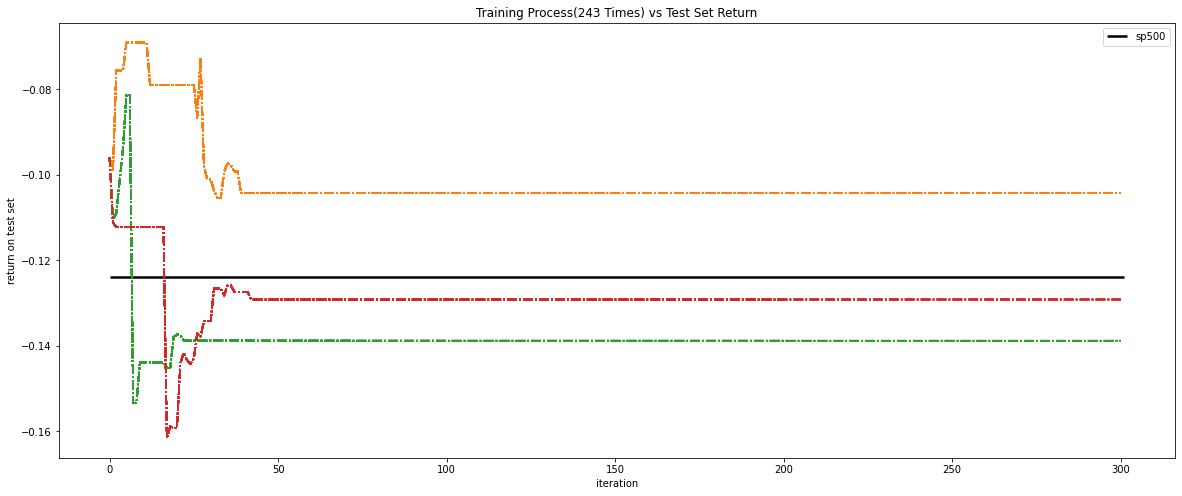

In [17]:
max_range = 0
label = {}

plt.figure(figsize=(20, 8))
for v in grid_result.values():
    if label.get(v['best_test_perfList'][-1]) is None:
        label[v['best_test_perfList'][-1]] = len(list(label.values())) + 1
        
    max_range = max(max_range, len(v['best_test_perfList']))
    x = list(range(len(v['best_test_perfList'])))
    
    plt.plot(
        x, 
        v['best_test_perfList'], 
        linestyle='-.', 
#         label=label[v['best_test_perfList'][-1]],
        color='C' + str(label[v['best_test_perfList'][-1]])
    )
    
plt.hlines(y=sp_whole_return, xmin=0, xmax=max_range, colors='black', linewidth=2.5, label='sp500')
plt.xlabel('iteration')
plt.ylabel('return on test set')
plt.title('Training Process(243 Times) vs Test Set Return')
plt.legend()
plt.show()

### 2015-01-01~2015-12-31

In [8]:
test2 = pd.read_csv(dataPath + '/test2.csv', index_col=0)
test2.index = pd.DatetimeIndex(pd.to_datetime(test2.index, format='%Y-%m-%d'))

In [9]:
test2.head()

,AAL,PNW,ABT,AMD,APD,ALK,HON,SWKS,HES,AEP,...,CBOE,FLT,HII,MPC,FBHS,XYL,CPRI,CBRE,LYB,ALLE
2015-01-02,54.28,68.58,45.25,2.70,143.39,60.54,100.20,73.60,73.19,60.88,...,63.88,149.04,112.49,89.55,45.62,38.40,75.56,34.51,79.94,55.49
2015-01-05,54.37,68.62,44.80,2.67,144.36,60.81,99.90,73.10,72.64,61.10,...,63.23,150.28,111.65,90.85,44.46,37.34,74.32,34.31,78.79,54.73
2015-01-06,54.27,68.20,44.99,2.65,141.49,59.78,98.30,72.20,69.88,60.42,...,65.75,143.41,111.74,89.13,44.39,35.70,69.27,34.04,76.44,55.00
2015-01-07,53.38,68.80,44.73,2.63,141.83,59.06,99.07,71.47,70.30,60.71,...,66.09,143.36,115.06,89.64,43.49,35.87,67.51,33.89,75.14,55.09
2015-01-08,53.48,70.21,45.19,2.59,142.90,60.00,99.64,72.00,70.21,61.63,...,67.58,144.26,115.08,89.97,44.26,36.01,69.10,34.24,76.05,55.71


In [11]:
for k, vDict in grid_result.items():
    grid_result[k]['best_test_perf_2'] = getPortfolioReturn(vDict['best_series'], test2)

In [33]:
pd.Series([vDict['best_test_perf_2'] for vDict in grid_result.values()]).describe().round(4).to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,243.0,0.0595,0.032,0.0156,0.0156,0.0725,0.0905,0.0905


In [ ]:
'''S&P500 2015 return percentage: 0.00979496648'''